# t-SNE on Tensorflow
initial: https://github.com/maestrojeong/t-SNE
 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
%matplotlib inline

## Parameters

In [2]:
ndata = 300 # 3000
image_shape = [28,28,1]
image_size = np.prod(image_shape)

---
## Mnist Dataset

In [33]:
mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)
train_images = mnist.train.images[:ndata]
train_labels = mnist.train.labels[:ndata]
test_images = mnist.test.images[:ndata]
test_labels = mnist.test.labels[:ndata]


Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


---
## t-SNE

In [4]:
def normalize(array):
    '''
    normalize for 1D array
    '''
    return array/np.sum(array)

def get_entropy(array):
    '''
    Calculate entropy for 1D array
    '''
    if np.sum(array) !=1:
        array = normalize(array)
        
    sum_ = 0
    length = len(array)
    for i in range(length):
        if array[i]!=0:
            sum_+=array[i]*np.log2(array[i])
    return -sum_

def get_prob(sigma_1d):
    '''
    prob[i][j] = p_{j|i}
    '''
    prob = np.zeros([ndata, ndata])
    for i in range(ndata):
        for j in range(ndata):
            prob[i][j] = np.exp(-sq_dist[i][j]/2/sigma_1d[i]/sigma_1d[i])
    
    #diagonal should be 0
    for i in range(ndata):
        prob[i][i] = 0 
    
    for i in range(ndata):
        prob[i] = normalize(prob[i])
    
    return prob

def get_prob_1d(row, sigma):
    '''
    prob[i][j] = p_{j|i}
    return prob[i]
    '''
    prob = np.zeros(ndata)
    for j in range(ndata):
        prob[j] = np.exp(-sq_dist[row][j]/2/sigma/sigma)
    
    #diagonal should be 0
    prob[row] = 0 
    
    return normalize(prob)


def get_perp(entropy):
    return np.power(2, entropy)

def get_shape(tensor):
    return tensor.get_shape().as_list()

def t_sne(y):
    '''
    Arg :
        y - 2D tensor [ndata, nmap]
    '''
    batch, nmap = get_shape(y)
    y_tr = tf.transpose(y)
    y_mapped = []
    for i in range(nmap):
        y_mapped.append(tf.transpose([y_tr[i]])-y_tr[i])
    y_square = 0
    for i in range(nmap):
        y_square+= tf.square(y_mapped[i])
    y_add = y_square+1
    y_div = tf.div(1., y_add)
    y_mask = y_div*(1-tf.eye(batch))
    y_sum = tf.reduce_sum(y_mask)
    y_normalize = y_mask/y_sum
    cost = -tf.reduce_mean(joint_prob*tf.log(clip(y_normalize)))
    return cost

def clip(x, vmax = 1-1e-10, vmin = 1e-10):
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

### Compute distances

In [7]:
%%time
sq_dist= np.zeros([ndata, ndata])
for i in range(ndata):
    clear_output(True)
    print("Computing distances: %.1f%% ..." % ((i+1)/ndata*100))
    for j in range(ndata):
        sq_dist[i][j] = np.sum(np.square(train_images[i]-train_images[j]))
print('Done.')

Computing distances: 100.0% ...
Done.
CPU times: user 2.21 s, sys: 300 ms, total: 2.51 s
Wall time: 2.13 s


### Compute probabilities

In [8]:
%%time

sigma = np.ones(ndata)

max_try = 2000
boundary = 1
perp = 20

for i in range(ndata):
    smax = np.max(sq_dist)
    smin = np.min(sq_dist)
    cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
    trial = 0
    perp_diff = np.abs(perp - cur_perp)
    clear_output(True)
    print("Computing sigma: %.1f%% ..." % ((i+1)/ndata*100))
    while perp_diff > boundary and trial < max_try:
        trial+=1
        if perp>cur_perp:
            smin = sigma[i]
            sigma[i] = (sigma[i]+smax)/2
        else: 
            smax = sigma[i]
            sigma[i] = (sigma[i]+smin)/2
        cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
        perp_diff = np.abs(perp - cur_perp)

prob = get_prob(sigma)
joint_prob = np.zeros((ndata, ndata))
for i in range(ndata):
    clear_output(True)
    print("Computing joint probs: %.1f%% ..." % ((i+1)/ndata*100))
    for j in range(ndata):
        joint_prob[i][j]=(prob[i][j]+prob[j][i])/2/ndata
        
print('Done.')

Computing joint probs: 100.0% ...
Done.
CPU times: user 13 s, sys: 220 ms, total: 13.2 s
Wall time: 13 s


---
## Visual routines

In [22]:
def PlotEmbedding3d(embeds, labels, title, figsize):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    colors = [np.argmax(labels[i]) for i in range(len(embeds))]
    ax.scatter(*zip(*embeds), c=colors, s=100)
    if title:
        plt.title(title)

def PlotEmbeddedDataset3d(images, labels, sess, emb_op, npoint=500, title=None, figsize=[10,10]):
    embeds = sess.run(embed_op, feed_dict = {
            image_pl : images
        })[:npoint]
    PlotEmbedding3d(
        embeds,
        labels[:npoint],
        title,
        figsize)

---
## TF Neural Networks

In [10]:
def Perceptron(inputs, out_dim):
    
    l = inputs
    l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=1000, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=2000, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    
    outputs = l
    
    return outputs

In [11]:
def ConvNet(inputs, inp_shape, out_dim):
        l =  tf.reshape(inputs, [-1,] + inp_shape)
        
        l = tf.layers.conv2d(
            inputs=l,
            filters=16,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.layers.conv2d(
            inputs=l,
            filters=32,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.layers.conv2d(
            inputs=l,
            filters=64,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=out_dim)
        return l

### Graph

In [36]:
batch_size = ndata
learning_rate = 3e-4

# TODO: use small batches

image_pl = tf.placeholder(dtype = tf.float32, shape = [batch_size, image_size], name = 'image_pl')
embed_op = ConvNet(inputs=image_pl, inp_shape=image_shape, out_dim=3)
cost = t_sne(embed_op)*10000
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Train

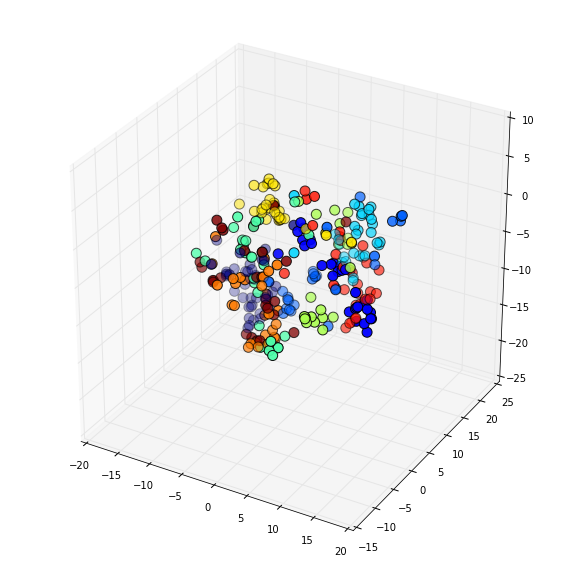

Step: 190/2000, Cost: 1.05e+00
CPU times: user 12.8 s, sys: 3.58 s, total: 16.4 s
Wall time: 12.2 s


In [37]:
%%time
train_steps = 2000
log_every = 10

cost_tract = []
sess= tf.Session()
sess.run(tf.global_variables_initializer())

def plot_train_batch(images, labels, title=None):
    PlotEmbeddedDataset3d(
        images, 
        labels, 
        sess, 
        embed_op, 
        500,
        title)

try:
    for step in range(train_steps):
        b_images = train_images[:batch_size]
        b_labels = train_labels[:batch_size]
        
        _, c = sess.run([train_op, cost], feed_dict={
            image_pl : b_images
        })
        cost_tract.append(c)
        
        if step%log_every == log_every - 1:
            clear_output(True)
            progress = "Step: %d/%d, Cost: %.2e" % (step+1, train_steps, c)
            plot_train_batch(b_images, b_labels, progress)
            plt.show()            
except KeyboardInterrupt:
    pass

clear_output(True)
plot_train_batch(b_images, b_labels)
plt.show()
#plt.plot(cost_tract)
#plt.show()
print(progress)

### Validate

In [25]:
PlotEmbeddedDataset3d(train_images[:batch_size], train_labels[:batch_size], sess, embed_op, 2000, "Train data")
plt.show()
PlotEmbeddedDataset3d(test_images[:batch_size], test_labels[:batch_size], sess, embed_op, 2000, "Test data")
plt.show()

SyntaxError: invalid syntax (<ipython-input-25-b07c03d86347>, line 1)